In [52]:
!pip install git+https://github.com/modAL-python/modAL.git
!pip install torchmetrics
!pip install torchinfo

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-japm_6jw
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-japm_6jw
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


In [53]:
import numpy as np
import torch
import torch.nn as nn
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt

In [54]:
transformation = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
    
])

In [55]:
train_data = torchvision.datasets.CIFAR10('/data',train=True,download =True,transform=transformation)
test_data = torchvision.datasets.CIFAR10('/data',train=False,download =True,transform=transformation)


Files already downloaded and verified
Files already downloaded and verified


In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [58]:
len(test_data)

10000

In [59]:
train_loader = DataLoader(train_data,batch_size=50000,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10000,shuffle=False)

In [60]:
feature,labels = next(iter(test_loader))

In [61]:
feature[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'tensor(6)')

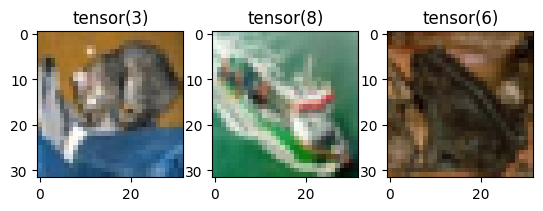

In [62]:
plt.subplot(1,3,1)
plt.imshow(feature[0].permute(1,2,0))
plt.title(labels[0])
plt.subplot(1,3,2)
plt.imshow(feature[15].permute(1,2,0))
plt.title(labels[15])
plt.subplot(1,3,3)
plt.imshow(feature[30].permute(1,2,0))
plt.title(labels[30])

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [64]:
model = torchvision.models.resnet18().to(device)

In [65]:
from torchinfo import summary
summary(model,[50000,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [50000, 1000]             --
├─Conv2d: 1-1                            [50000, 64, 16, 16]       9,408
├─BatchNorm2d: 1-2                       [50000, 64, 16, 16]       128
├─ReLU: 1-3                              [50000, 64, 16, 16]       --
├─MaxPool2d: 1-4                         [50000, 64, 8, 8]         --
├─Sequential: 1-5                        [50000, 64, 8, 8]         --
│    └─BasicBlock: 2-1                   [50000, 64, 8, 8]         --
│    │    └─Conv2d: 3-1                  [50000, 64, 8, 8]         36,864
│    │    └─BatchNorm2d: 3-2             [50000, 64, 8, 8]         128
│    │    └─ReLU: 3-3                    [50000, 64, 8, 8]         --
│    │    └─Conv2d: 3-4                  [50000, 64, 8, 8]         36,864
│    │    └─BatchNorm2d: 3-5             [50000, 64, 8, 8]         128
│    │    └─ReLU: 3-6                    [50000, 64, 8, 8]         --
│

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [67]:
X_train,y_train = next(iter(train_loader))
X_test,y_test = next(iter(test_loader))


In [68]:
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score
from skorch.callbacks import EpochScoring
accuracy = EpochScoring(scoring='accuracy', lower_is_better=False)

net = NeuralNetClassifier(
    module = model, 
    max_epochs=10, 
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    callbacks=[accuracy],
    device =device
)

In [69]:
import torch.nn.functional as F
net.fit(X_train, y_train)
val_accuracy = accuracy_score(y_true=y_test, y_pred=net.predict(X_test))  
print("Validation Accuracy:", val_accuracy)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.4162        1.9222       0.4162        1.6426  13.4864
      2      0.5054        1.3629       0.5054        1.4034  13.5643
      3      0.5262        1.1306       0.5262        1.3663  13.7266
      4      0.5763        0.9669       0.5763        1.2654  13.8087
      5      0.6575        0.8163       0.6575        1.0149  13.9094
      6      0.6155        0.7094       0.6155        1.2395  14.0142
      7      0.5830        0.6197       0.5830        1.4449  14.0839
      8      0.6482        0.5331       0.6482        1.1954  14.1610
      9      0.6452        0.4487       0.6452        1.3422  14.2396
     10      0.6815        0.3752       0.6815        1.2297  14.3183
Validation Accuracy: 0.6757


## random sample

In [70]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:4507]
y_pool = np.delete(y_train, initial_idx, axis=0)[:4507]

In [71]:
from modAL.models import ActiveLearner

# initialize ActiveLearner
learner = ActiveLearner(
    estimator=net,
    X_training=X_initial, y_training=y_initial,
)

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      1.0000        4.3691       1.0000        0.0570  0.0328
      2      0.0000        4.1654       0.0000        3.7372  0.0334
      3      0.0000        3.9612       0.0000       13.4844  0.0347
      4      0.0000        3.7535       0.0000       19.8171  0.0346
      5      0.0000        3.5416       0.0000       21.1525  0.0340
      6      0.0000        3.3303       0.0000       20.3119  0.0344
      7      0.0000        3.1193       0.0000       18.9628  0.0341
      8      0.0000        2.9069       0.0000       15.8771  0.0343
      9      0.0000        2.7011       0.0000       12.5179  0.0334
     10      0.0000        2.4919       0.0000       10.0862  0.0327


In [72]:
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
loss_random = net.history[:,'valid_loss']
accuracy_random = net.history[:,'valid_acc']

Query no. 1
Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2500        2.6445       0.2500        3.3860  0.0320
      2      0.3000        0.3586       0.3000        3.5818  0.0341
      3      0.4000        0.0942       0.4000        3.6723  0.0347
      4      0.4000        0.0450       0.4000        3.7135  0.0343
      5      0.4500        0.0255       0.4500        3.6774  0.0342
      6      0.3500        0.0162       0.3500        3.5885  0.0345
      7      0.3500        0.0116       0.3500        3.4799  0.0344
      8      0.3500        0.0086       0.3500        3.3832  0.0342
      9      0.3000        0.0065       0.3000        3.2813  0.0335
     10      0.3500        0.0049       0.3500        3.1769  0.0340
Query no. 2
Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ----

## entropy sample

In [73]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:50000]
y_pool = np.delete(y_train, initial_idx, axis=0)[:50000]

In [74]:
import modAL
from modAL.models import ActiveLearner
learner = ActiveLearner(
    estimator=net,
    query_strategy=modAL.uncertainty.entropy_sampling,
    X_training=X_train, y_training=y_train
)
loss_entropy = net.history[:,'valid_loss']
accuracy_entropy = net.history[:,'valid_acc']
val_accuracy = accuracy_score(y_true=y_test, y_pred=learner.predict(X_test))
print("Validation Accuracy:", val_accuracy)
# modAL.disagreement.consensus_entropy_sampling

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.6872        0.4301       0.6872        1.1501  14.4063
      2      0.6401        0.2903       0.6401        1.6182  14.4533
      3      0.6652        0.2475       0.6652        1.5333  14.4817
      4      0.6476        0.2008       0.6476        1.7212  14.5190
      5      0.6805        0.1704       0.6805        1.4712  14.5583
      6      0.6950        0.1439       0.6950        1.5025  14.6239
      7      0.7057        0.1192       0.7057        1.5069  14.6533
      8      0.7178        0.1087       0.7178        1.4101  14.7319
      9      0.7003        0.0998       0.7003        1.6925  14.6906
     10      0.6929        0.0840       0.6929        1.7731  14.7074
Validation Accuracy: 0.6941


## make random prediction

[array([6]), array([6]), array([9]), array([8]), array([6])]
[tensor(6), tensor(6), tensor(2), tensor(8), tensor(6)]
[5743, 1140, 3506, 7868, 3941]


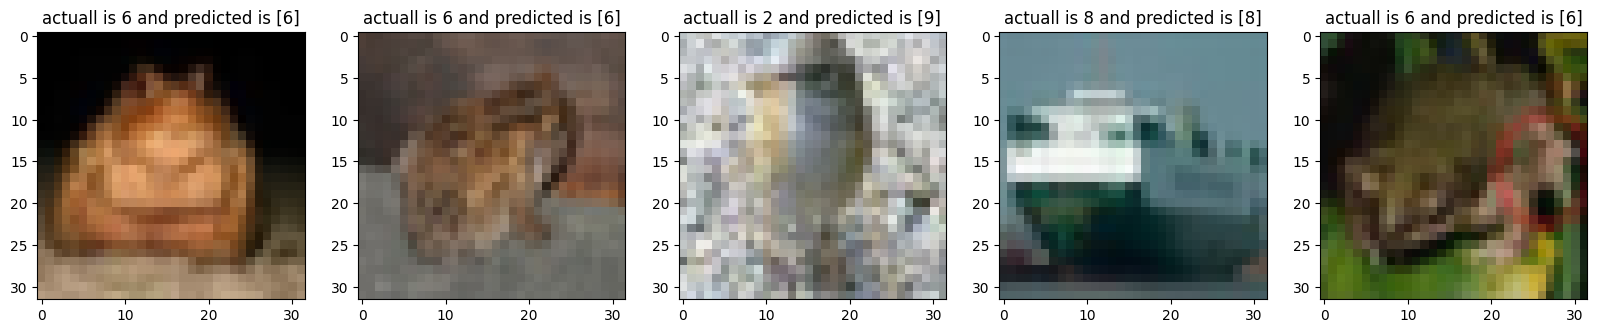

In [75]:
predictions =[]
actuall =[]
sample = []
for i in range(5):
    random_integer = np.random.randint(10000)
    pred = learner.predict(X_test[random_integer].unsqueeze(dim=0))
    predictions.append(pred)
    actuall.append(y_test[random_integer])
    sample.append(random_integer)
print(predictions)
print(actuall)
print(sample)
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[sample[i]].permute(1,2,0))
    plt.title(f'actuall is {actuall[i]} and predicted is {predictions[i]}')
    

## uncertainty sampling


In [76]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:50000]
y_pool = np.delete(y_train, initial_idx, axis=0)[:50000]

In [77]:
from modAL.models import ActiveLearner
learner = ActiveLearner(
    estimator=net,
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train, y_training=y_train
)
loss_uncert = net.history[:,'valid_loss']
accuracy_uncert = net.history[:,'valid_acc']
val_accuracy = accuracy_score(y_true=y_test, y_pred=learner.predict(X_test))
print("Validation Accuracy:", val_accuracy)

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.6961        0.0922       0.6961        1.7767  14.6676
      2      0.6938        0.0915       0.6938        1.7460  14.7287
      3      0.7040        0.0874       0.7040        1.6812  14.6920
      4      0.7255        0.0913       0.7255        1.5155  14.7641
      5      0.7022        0.0656       0.7022        1.8050  14.6994
      6      0.7265        0.0618       0.7265        1.6328  14.7002
      7      0.7217        0.0561       0.7217        1.5996  14.6959
      8      0.7195        0.0541       0.7195        1.7488  14.6950
      9      0.7263        0.0808       0.7263        1.5802  14.6955
     10      0.7149        0.0516       0.7149        1.6807  14.6977
Validation Accuracy: 0.7155


[array([6]), array([6]), array([1]), array([2]), array([3])]
[tensor(4), tensor(6), tensor(1), tensor(5), tensor(3)]
[5241, 4989, 2645, 1636, 4464]


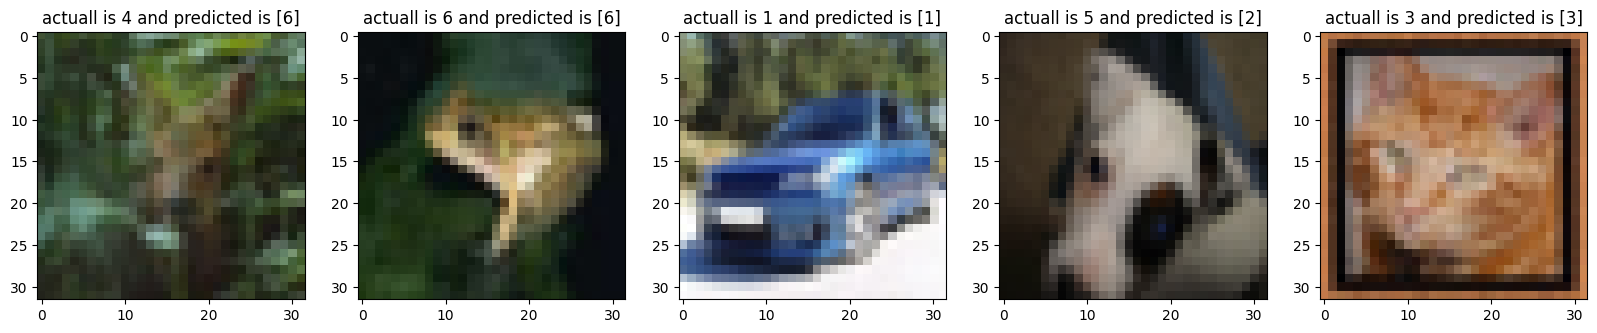

In [78]:
predictions =[]
actuall =[]
sample = []
for i in range(5):
    random_integer = np.random.randint(10000)
    pred = learner.predict(X_test[random_integer].unsqueeze(dim=0))
    predictions.append(pred)
    actuall.append(y_test[random_integer])
    sample.append(random_integer)
print(predictions)
print(actuall)
print(sample)
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[sample[i]].permute(1,2,0))
    plt.title(f'actuall is {actuall[i]} and predicted is {predictions[i]}')
    

## disagrement

In [79]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:50000]
y_pool = np.delete(y_train, initial_idx, axis=0)[:50000]

In [80]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
learner = ActiveLearner(
    estimator=net,
    query_strategy=modAL.disagreement.consensus_entropy_sampling,
    X_training=X_train, y_training=y_train
)
loss_dis = net.history[:,'valid_loss']
accuracy_dis = net.history[:,'valid_acc']
val_accuracy = accuracy_score(y_true=y_test, y_pred=learner.predict(X_test))
print("Validation Accuracy:", val_accuracy)

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.7259        0.0648       0.7259        1.6346  14.7056
      2      0.7335        0.0496       0.7335        1.6470  14.6541
      3      0.7219        0.1411       0.7219        1.2438  14.6605
      4      0.7361        0.0474       0.7361        1.5701  14.6603
      5      0.7383        0.0233       0.7383        1.8075  14.6767
      6      0.7290        0.0323       0.7290        1.8441  14.6650
      7      0.7315        0.0414       0.7315        1.6736  14.6682
      8      0.7234        0.0399       0.7234        1.8351  14.6736
      9      0.7350        0.0501       0.7350        1.6551  14.6811
     10      0.7175        0.0525       0.7175        1.7988  14.6681
Validation Accuracy: 0.7058


[array([5]), array([8]), array([3]), array([6]), array([6])]
[tensor(5), tensor(8), tensor(5), tensor(6), tensor(6)]
[5915, 8725, 5468, 1029, 7700]


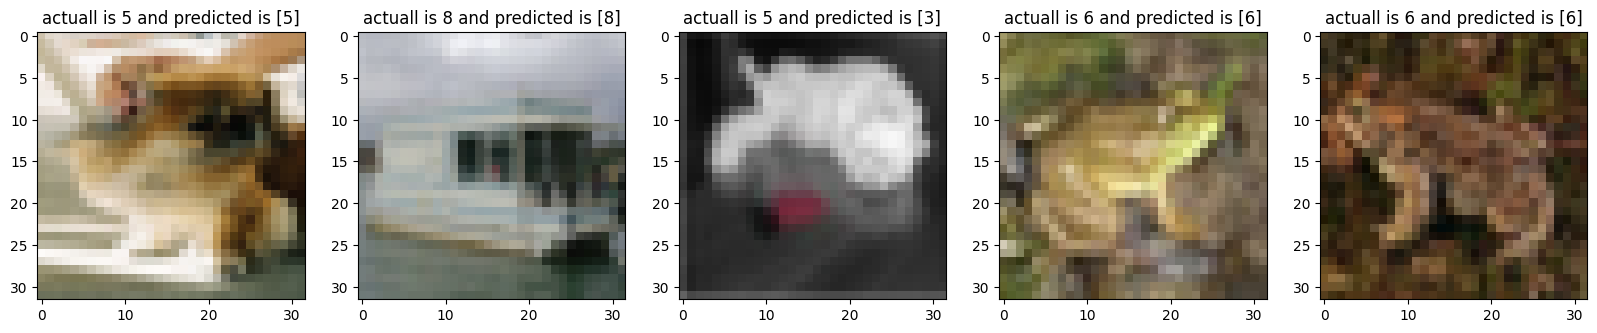

In [86]:
predictions =[]
actuall =[]
sample = []
for i in range(5):
    random_integer = np.random.randint(10000)
    pred = learner.predict(X_test[random_integer].unsqueeze(dim=0))
    predictions.append(pred)
    actuall.append(y_test[random_integer])
    sample.append(random_integer)
print(predictions)
print(actuall)
print(sample)
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[sample[i]].permute(1,2,0))
    plt.title(f'actuall is {actuall[i]} and predicted is {predictions[i]}')
    

In [82]:
epoches = net.history[:,'epoch']

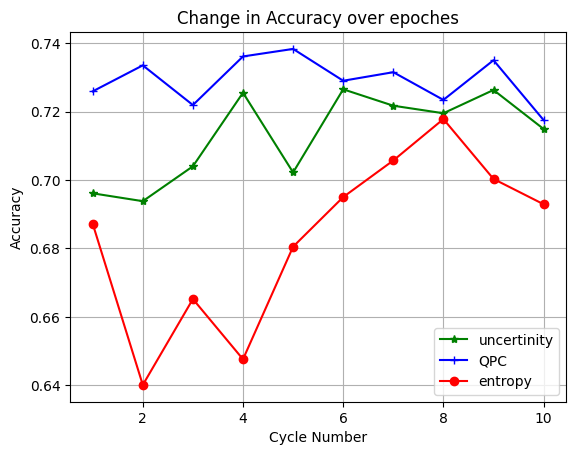

In [83]:
from matplotlib import pyplot as plt
plt.plot(epoches, accuracy_uncert, label='uncertinity',color='green',marker='*')
plt.plot(epoches, accuracy_dis,label='QPC',color='blue',marker='+')
plt.plot(epoches, accuracy_entropy,label='entropy',color='red',marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy over epoches')
plt.legend()
plt.grid(True)
plt.show()


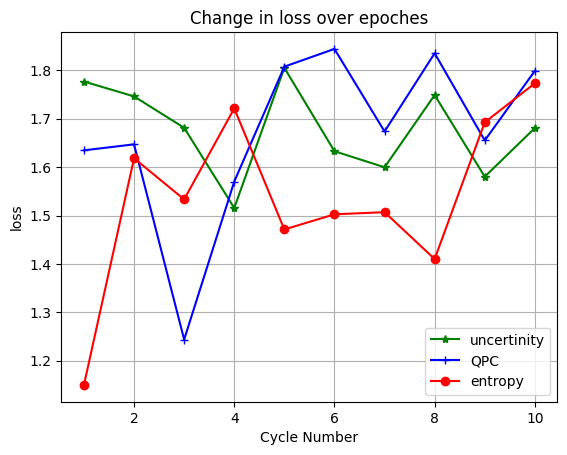

In [84]:
from matplotlib import pyplot as plt
plt.plot(epoches, loss_uncert, label='uncertinity',color='green',marker='*')
plt.plot(epoches, loss_dis,label='QPC',color='blue',marker='+')
plt.plot(epoches, loss_entropy,label='entropy',color='red',marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('loss')
plt.title('Change in loss over epoches')
plt.legend()
plt.grid(True)
plt.show()
